<a href="https://colab.research.google.com/github/Aribabo/Homework/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%A1%B0%EB%B3%841%EC%B0%A8%EA%B3%BC%EC%A0%9C%EC%A0%95%EB%A6%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 팀과제.
* 케글에서 이미지 데이터를 선택하여 해당 이미지를 분류하는 문제를 푸는 프로젝트를 작성
* 깃허브에 예쁘게 올리기
* 월요일까지
* https://www.kaggle.com/datasets/jehanbhathena/weather-dataset

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import random
import shutil

# 캐글 데이터 셋 다운 및 압축 해제

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'aribabo0117'
os.environ['KAGGLE_KEY'] = '2fcaa84dca4e865e76a0886ac4b24735'

In [ ]:
!kaggle datasets download -d jehanbhathena/weather-dataset

 99% 578M/587M [00:06<00:00, 126MB/s]
100% 587M/587M [00:06<00:00, 92.3MB/s]


In [ ]:
!unzip -q weather-dataset.zip

# train / validation 폴더나눠서 저장

In [ ]:
def split_dataset_by_class(dataset_path, train_path, validation_path, validation_ratio=0.2):
    # 클래스 폴더 목록 가져오기
    classes = os.listdir(dataset_path)

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        train_class_path = os.path.join(train_path, class_name)
        validation_class_path = os.path.join(validation_path, class_name)

        # 폴더 생성
        if not os.path.exists(train_class_path):
            os.makedirs(train_class_path)
        if not os.path.exists(validation_class_path):
            os.makedirs(validation_class_path)

        # 클래스 폴더 내의 파일 목록 가져오기
        file_list = os.listdir(class_path)

        # 클래스 별 데이터셋 섞기
        random.shuffle(file_list)

        # 클래스 별 데이터셋을 train과 validation으로 나누기
        num_validation = int(len(file_list) * validation_ratio)
        validation_files = file_list[:num_validation]
        train_files = file_list[num_validation:]

        # validation 폴더로 파일 이동
        for file in validation_files:
            src_path = os.path.join(class_path, file)
            dest_path = os.path.join(validation_class_path, file)
            shutil.move(src_path, dest_path)

        # train 폴더로 파일 이동
        for file in train_files:
            src_path = os.path.join(class_path, file)
            dest_path = os.path.join(train_class_path, file)
            shutil.move(src_path, dest_path)

dataset_path = 'dataset'
train_path = 'train'
validation_path = 'validation'

split_dataset_by_class(dataset_path, train_path, validation_path, validation_ratio=0.2)

In [ ]:
train_list_dew = os.listdir('train/dew')
valid_list_dew = os.listdir('validation/dew')

print(len(train_list_dew), len(valid_list_dew))

559 139


# 데이터 증강 및 배치 사이즈 32로 설정

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

def target_transforms(target):
    return torch.FloatTensor([target])

image_datasets = {
    'train': datasets.ImageFolder('train', data_transforms['train']),
    'validation': datasets.ImageFolder('validation', data_transforms['validation'])
}

cuda


In [ ]:
data = os.listdir("dataset")
print(data)
print(len(data))

['snow', 'dew', 'hail', 'rain', 'glaze', 'rime', 'frost', 'sandstorm', 'fogsmog', 'lightning', 'rainbow']
11


In [ ]:
print(len(image_datasets['train']), len(image_datasets['validation']))

5493 1369


In [ ]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

x_batch, y_batch = next(iter(dataloaders['train']))
print(y_batch.shape)
print(x_batch.shape)

torch.Size([32])
torch.Size([32, 3, 224, 224])


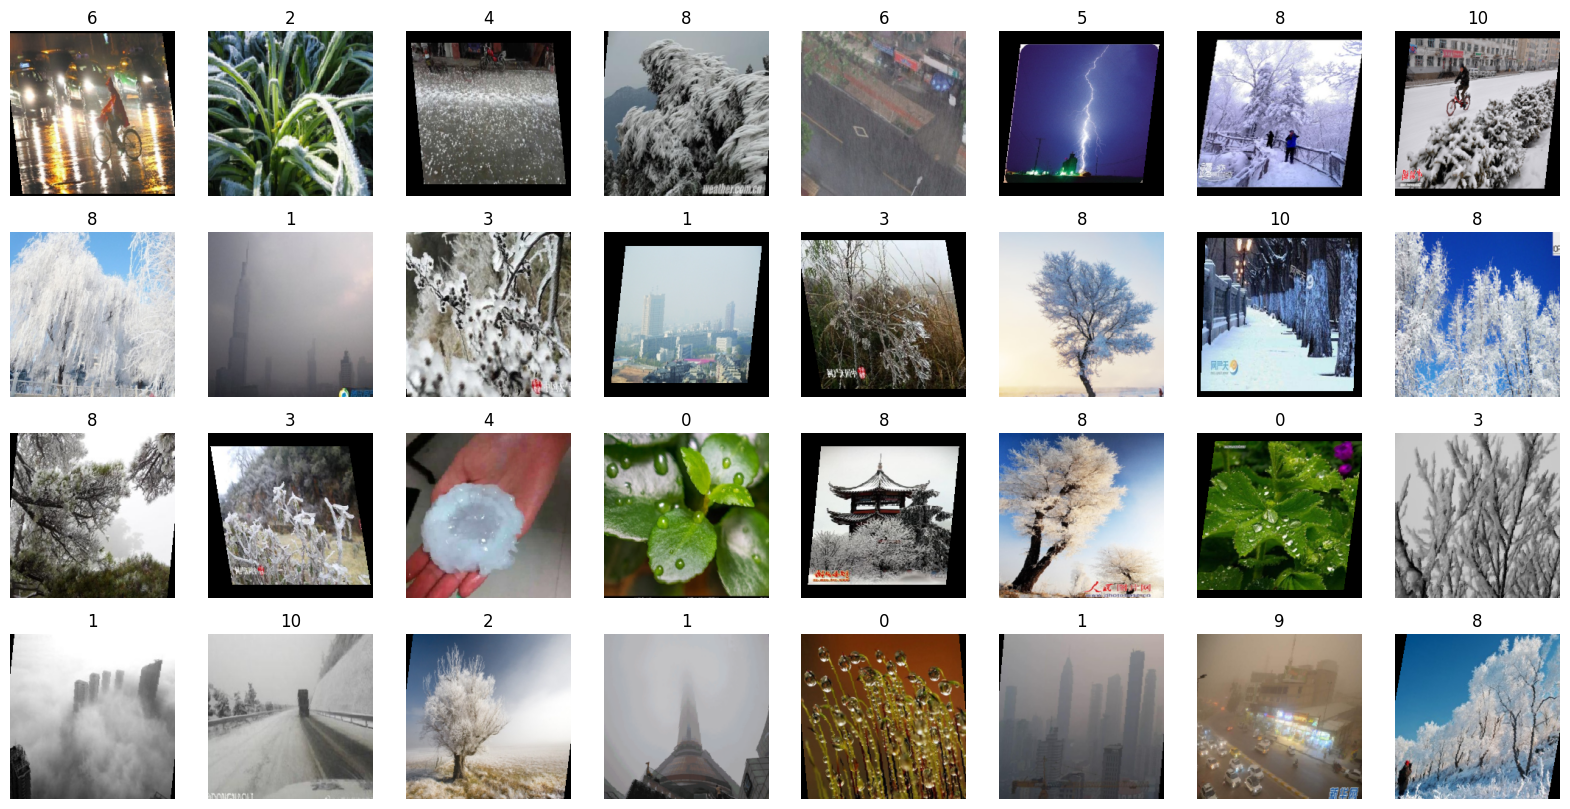

In [ ]:
imgs, labels = next(iter(dataloaders['train']))
fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
    ax.set_title(label.item())
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')

# VGG 16 모델 사용


VGG-16은 영상 인식 및 분류 작업을 위한 심층 합성곱 신경망(Convolutional Neural Network, CNN) 아키텍처 중 하나입니다. VGG-16은 Oxford 대학에서 개발한 VGGNet의 한 변종으로, 2014년 ILSVRC(ImageNet Large Scale Visual Recognition Challenge)에서 우승한 모델 중 하나입니다. 이 아키텍처는 모델 내에 많은 층(layer)을 가지고 있으며, 그 중 16개의 합성곱 및 완전 연결 층이 있습니다.

* 아키텍처 구조:
입력층 (Input Layer): 224x224 크기의 컬러 이미지를 입력으로 받습니다.

* 합성곱 블록 (Convolutional Blocks): VGG-16은 13개의 합성곱 층으로 이루어진 5개의 합성곱 블록을 가지고 있습니다. 각 블록은 2개 또는 3개의 합성곱 층과 풀링 층으로 구성되어 있습니다. 층의 필터 크기는 3x3, 스트라이드는 1x1이고, 풀링은 2x2 크기의 맥스 풀링을 사용합니다.

* 완전 연결층 (Fully Connected Layers): 합성곱 블록 다음에는 3개의 완전 연결층이 이어지며, 마지막 층은 클래스의 개수에 해당하는 출력을 생성합니다.

* 활성화 함수: 주로 ReLU(Rectified Linear Unit) 활성화 함수를 사용합니다.

* 장점:
    * 깊은 구조: VGG-16은 깊은 네트워크 구조를 가지고 있어, 복잡한 특징을 학습할 수 있습니다.

    * 간결성: 비교적 간단한 디자인으로 이해하기 쉽고, 구현이 비교적 쉽습니다.

    * Transfer Learning: 사전 훈련된 VGG-16 모델은 다양한 이미지 관련 작업에서 효과적으로 사용될 수 있는 좋은 특징 추출기로 사용될 수 있습니다.

* 단점:
매우 많은 매개변수: VGG-16은 매우 많은 가중치를 가진다는 단점이 있어, 학습 및 예측 시에 높은 계산 비용이 발생할 수 있습니다.

    * 계산 비용: 대규모의 이미지 데이터셋에서 훈련시키기 위해서는 상당한 계산 비용이 필요합니다.

    * 과적합 위험: VGG-16은 매우 많은 파라미터를 갖고 있기 때문에, 작은 규모의 데이터셋에서는 과적합(overfitting)의 위험이 높을 수 있습니다.

    * 공간 및 메모리 요구: 모델의 크기가 크기 때문에 모델을 배포하거나 제한된 환경에서 사용하기 어려울 수 있습니다.

### model_training 함수 설정


In [ ]:
def model_training(model, epochs):
    for epoch in  range(epochs):
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            sum_losses = 0
            sum_accs = 0
            for x_batch, y_batch in dataloaders[phase]:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                y_pred = model(x_batch)
                loss = nn.CrossEntropyLoss()(y_pred, y_batch)
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                sum_losses = sum_losses + loss
                y_prob = nn.Softmax(1)(y_pred)
                y_pred_index = torch.argmax(y_prob, axis=1)
                acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
                sum_accs = sum_accs + acc
            avg_loss = sum_losses / len(dataloaders[phase])
            avg_acc = sum_accs / len(dataloaders[phase])
            print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc: .2f}%')

In [ ]:
model = models.vgg16(pretrained=True)

model.classifier

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 108MB/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
# VGG16 모델 가져오기
model = models.vgg16(pretrained=True)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1000),
    nn.ReLU(),
    nn.Linear(1000, 512),
    nn.ReLU(),
    nn.Linear(512, 11),
).to(device)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# 학습
optimizer = optim.Adam(model.classifier.parameters(), lr=0.002)

model_training(model,10)

train     : Epoch    1/10 Loss: 1.1462 Accuracy:  63.54%
validation: Epoch    1/10 Loss: 0.6770 Accuracy:  76.59%
train     : Epoch    2/10 Loss: 0.6280 Accuracy:  79.01%
validation: Epoch    2/10 Loss: 0.6790 Accuracy:  77.24%
train     : Epoch    3/10 Loss: 0.4973 Accuracy:  83.58%
validation: Epoch    3/10 Loss: 0.7019 Accuracy:  79.53%
train     : Epoch    4/10 Loss: 0.4300 Accuracy:  85.83%
validation: Epoch    4/10 Loss: 0.5822 Accuracy:  81.90%
train     : Epoch    5/10 Loss: 0.3670 Accuracy:  88.45%
validation: Epoch    5/10 Loss: 0.7493 Accuracy:  79.32%
train     : Epoch    6/10 Loss: 0.3586 Accuracy:  89.11%
validation: Epoch    6/10 Loss: 0.7327 Accuracy:  81.78%
train     : Epoch    7/10 Loss: 0.3250 Accuracy:  89.87%
validation: Epoch    7/10 Loss: 0.6931 Accuracy:  83.42%
train     : Epoch    8/10 Loss: 0.2777 Accuracy:  91.41%
validation: Epoch    8/10 Loss: 0.7696 Accuracy:  81.17%
train     : Epoch    9/10 Loss: 0.2556 Accuracy:  92.15%
validation: Epoch    9/10 Loss:

In [ ]:
# VGG16 모델 가져오기
model2 = models.vgg16(pretrained=True)
model2 = model.to(device)

for param in model.parameters():
    param.requires_grad = False

model2.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4096, 1000),
    nn.ReLU(),
    nn.Linear(1000, 512),
    nn.ReLU(),
    nn.Linear(512, 11),
).to(device)

print(model2.classifier)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
  (7): ReLU()
  (8): Linear(in_features=1000, out_features=512, bias=True)
  (9): ReLU()
  (10): Linear(in_features=512, out_features=11, bias=True)
)


In [ ]:
# 학습
optimizer = optim.Adam(model2.classifier.parameters(), lr=0.002)
model_training(model2,10)

train     : Epoch    1/10 Loss: 1.3851 Accuracy:  52.00%
validation: Epoch    1/10 Loss: 0.8749 Accuracy:  67.67%
train     : Epoch    2/10 Loss: 0.8912 Accuracy:  69.60%
validation: Epoch    2/10 Loss: 0.7726 Accuracy:  71.90%
train     : Epoch    3/10 Loss: 0.7512 Accuracy:  73.65%
validation: Epoch    3/10 Loss: 0.7819 Accuracy:  71.54%
train     : Epoch    4/10 Loss: 0.6855 Accuracy:  76.66%
validation: Epoch    4/10 Loss: 0.5960 Accuracy:  79.33%
train     : Epoch    5/10 Loss: 0.5930 Accuracy:  81.12%
validation: Epoch    5/10 Loss: 0.6345 Accuracy:  80.49%
train     : Epoch    6/10 Loss: 0.5561 Accuracy:  82.47%
validation: Epoch    6/10 Loss: 0.6277 Accuracy:  79.68%
train     : Epoch    7/10 Loss: 0.5303 Accuracy:  83.55%
validation: Epoch    7/10 Loss: 0.6037 Accuracy:  82.04%
train     : Epoch    8/10 Loss: 0.4929 Accuracy:  84.69%
validation: Epoch    8/10 Loss: 0.6428 Accuracy:  80.20%
train     : Epoch    9/10 Loss: 0.4379 Accuracy:  86.06%
validation: Epoch    9/10 Loss:

In [ ]:
model_training(model2,5)

train     : Epoch    1/5 Loss: 0.3777 Accuracy:  88.03%
validation: Epoch    1/5 Loss: 0.5926 Accuracy:  82.82%
train     : Epoch    2/5 Loss: 0.3613 Accuracy:  88.93%
validation: Epoch    2/5 Loss: 0.6642 Accuracy:  82.99%
train     : Epoch    3/5 Loss: 0.3623 Accuracy:  88.50%
validation: Epoch    3/5 Loss: 0.7804 Accuracy:  82.17%
train     : Epoch    4/5 Loss: 0.3508 Accuracy:  89.74%
validation: Epoch    4/5 Loss: 0.8268 Accuracy:  81.14%
train     : Epoch    5/5 Loss: 0.3776 Accuracy:  88.65%
validation: Epoch    5/5 Loss: 0.8603 Accuracy:  80.88%
train     : Epoch    6/5 Loss: 0.3963 Accuracy:  89.01%
validation: Epoch    6/5 Loss: 0.7321 Accuracy:  82.52%


In [ ]:
# VGG16 모델 가져오기
model3 = models.vgg16(pretrained=True)
model3 = model.to(device)

for param in model.parameters():
    param.requires_grad = False

model3.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4096, 1000),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1000, 512),
    nn.ReLU(),
    nn.Linear(512, 11),
).to(device)

print(model3.classifier)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=4096, out_features=1000, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=1000, out_features=512, bias=True)
  (7): ReLU()
  (8): Linear(in_features=512, out_features=11, bias=True)
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(model3.classifier.parameters(), lr=0.002)

model_training(model3,10)

train     : Epoch    1/10 Loss: 1.1878 Accuracy: 61.38%
validation: Epoch    1/10 Loss: 0.7542 Accuracy: 76.04%
train     : Epoch    2/10 Loss: 0.7131 Accuracy: 75.03%
validation: Epoch    2/10 Loss: 0.7384 Accuracy: 77.55%
train     : Epoch    3/10 Loss: 0.5897 Accuracy: 81.22%
validation: Epoch    3/10 Loss: 0.6666 Accuracy: 79.40%
train     : Epoch    4/10 Loss: 0.5387 Accuracy: 82.68%
validation: Epoch    4/10 Loss: 0.6074 Accuracy: 81.40%
train     : Epoch    5/10 Loss: 0.4738 Accuracy: 85.25%
validation: Epoch    5/10 Loss: 0.6649 Accuracy: 80.63%
train     : Epoch    6/10 Loss: 0.4378 Accuracy: 86.34%
validation: Epoch    6/10 Loss: 0.6944 Accuracy: 81.48%
train     : Epoch    7/10 Loss: 0.4174 Accuracy: 86.80%
validation: Epoch    7/10 Loss: 0.6459 Accuracy: 81.68%
train     : Epoch    8/10 Loss: 0.3574 Accuracy: 88.78%
validation: Epoch    8/10 Loss: 0.6346 Accuracy: 81.33%
train     : Epoch    9/10 Loss: 0.3379 Accuracy: 89.79%
validation: Epoch    9/10 Loss: 0.7076 Accuracy:

In [ ]:
optimizer = optim.Adam(model3.classifier.parameters(), lr=0.001)

model_training(model3,15)

train     : Epoch    1/5 Loss: 0.2821 Accuracy: 91.68%
validation: Epoch    1/5 Loss: 0.6936 Accuracy: 83.44%
train     : Epoch    2/5 Loss: 0.2647 Accuracy: 91.56%
validation: Epoch    2/5 Loss: 0.9225 Accuracy: 83.49%
train     : Epoch    3/5 Loss: 0.2589 Accuracy: 92.52%
validation: Epoch    3/5 Loss: 0.7896 Accuracy: 83.66%
train     : Epoch    4/5 Loss: 0.2196 Accuracy: 93.27%
validation: Epoch    4/5 Loss: 1.1330 Accuracy: 83.64%
train     : Epoch    5/5 Loss: 0.2102 Accuracy: 93.40%
validation: Epoch    5/5 Loss: 0.7942 Accuracy: 83.81%


In [ ]:
# VGG16 모델 가져오기
model4 = models.vgg16(pretrained=True)
model4 = model4.to(device)

for param in model4.parameters():
    param.requires_grad = False

model4.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 11),
).to(device)

optimizer = optim.Adam(model4.classifier.parameters(), lr=0.001)
model_training(model4,15)

train     : Epoch    1/15 Loss: 1.2389 Accuracy:  56.21%
validation: Epoch    1/15 Loss: 0.6400 Accuracy:  77.47%
train     : Epoch    2/15 Loss: 0.7628 Accuracy:  73.43%
validation: Epoch    2/15 Loss: 0.5640 Accuracy:  80.94%
train     : Epoch    3/15 Loss: 0.6581 Accuracy:  77.05%
validation: Epoch    3/15 Loss: 0.5597 Accuracy:  80.04%
train     : Epoch    4/15 Loss: 0.5744 Accuracy:  81.05%
validation: Epoch    4/15 Loss: 0.5862 Accuracy:  81.29%
train     : Epoch    5/15 Loss: 0.5151 Accuracy:  82.28%
validation: Epoch    5/15 Loss: 0.4839 Accuracy:  84.77%
train     : Epoch    6/15 Loss: 0.4871 Accuracy:  84.59%
validation: Epoch    6/15 Loss: 0.5600 Accuracy:  82.26%
train     : Epoch    7/15 Loss: 0.4431 Accuracy:  85.25%
validation: Epoch    7/15 Loss: 0.5304 Accuracy:  83.67%
train     : Epoch    8/15 Loss: 0.4079 Accuracy:  86.56%
validation: Epoch    8/15 Loss: 0.5334 Accuracy:  83.80%
train     : Epoch    9/15 Loss: 0.4087 Accuracy:  86.92%
validation: Epoch    9/15 Loss:

In [ ]:
torch.save(model4.state_dict(),'/content/drive/MyDrive/KDT-챗봇 프로젝트/1차 과제/이정흔/모델/vgg16_907_844.pth')

In [ ]:
model_training(model4,5)

train     : Epoch    1/5 Loss: 0.2926 Accuracy:  90.70%
validation: Epoch    1/5 Loss: 0.5669 Accuracy:  84.71%
train     : Epoch    2/5 Loss: 0.2774 Accuracy:  90.95%
validation: Epoch    2/5 Loss: 0.6467 Accuracy:  86.31%
train     : Epoch    3/5 Loss: 0.2768 Accuracy:  91.20%
validation: Epoch    3/5 Loss: 0.6389 Accuracy:  84.98%
train     : Epoch    4/5 Loss: 0.2799 Accuracy:  91.89%
validation: Epoch    4/5 Loss: 0.5919 Accuracy:  85.94%
train     : Epoch    5/5 Loss: 0.2598 Accuracy:  92.26%
validation: Epoch    5/5 Loss: 0.6203 Accuracy:  85.65%


In [ ]:
# VGG16 모델 가져오기
model5 = models.vgg16(pretrained=True)
model5 = model5.to(device)

for param in model5.parameters():
    param.requires_grad = False

model5.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 2048),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 32),
    nn.ReLU(),
    nn.Linear(32, 11),
).to(device)

optimizer = optim.Adam(model5.classifier.parameters(), lr=0.001)
model_training(model5,15)

train     : Epoch    1/15 Loss: 1.7173 Accuracy:  38.08%
validation: Epoch    1/15 Loss: 1.0854 Accuracy:  56.89%
train     : Epoch    2/15 Loss: 1.0742 Accuracy:  60.13%
validation: Epoch    2/15 Loss: 0.9513 Accuracy:  65.10%
train     : Epoch    3/15 Loss: 0.9126 Accuracy:  66.97%
validation: Epoch    3/15 Loss: 0.7448 Accuracy:  73.74%
train     : Epoch    4/15 Loss: 0.8004 Accuracy:  71.27%
validation: Epoch    4/15 Loss: 0.8508 Accuracy:  73.92%
train     : Epoch    5/15 Loss: 0.7391 Accuracy:  74.09%
validation: Epoch    5/15 Loss: 0.7043 Accuracy:  76.82%
train     : Epoch    6/15 Loss: 0.6888 Accuracy:  76.14%
validation: Epoch    6/15 Loss: 0.7877 Accuracy:  74.62%
train     : Epoch    7/15 Loss: 0.6655 Accuracy:  77.62%
validation: Epoch    7/15 Loss: 0.7062 Accuracy:  78.54%
train     : Epoch    8/15 Loss: 0.5902 Accuracy:  79.92%
validation: Epoch    8/15 Loss: 0.7705 Accuracy:  80.97%
train     : Epoch    9/15 Loss: 0.5894 Accuracy:  80.20%
validation: Epoch    9/15 Loss:

In [ ]:
model_training(model5,10)

train     : Epoch    1/10 Loss: 0.4393 Accuracy:  87.58%
validation: Epoch    1/10 Loss: 0.8104 Accuracy:  82.33%
train     : Epoch    2/10 Loss: 0.3891 Accuracy:  88.50%
validation: Epoch    2/10 Loss: 0.6766 Accuracy:  84.58%
train     : Epoch    3/10 Loss: 0.3630 Accuracy:  89.21%
validation: Epoch    3/10 Loss: 0.7164 Accuracy:  84.85%
train     : Epoch    4/10 Loss: 0.3814 Accuracy:  89.01%
validation: Epoch    4/10 Loss: 0.7492 Accuracy:  84.54%
train     : Epoch    5/10 Loss: 0.3785 Accuracy:  89.02%
validation: Epoch    5/10 Loss: 0.6906 Accuracy:  84.51%
train     : Epoch    6/10 Loss: 0.3622 Accuracy:  89.71%
validation: Epoch    6/10 Loss: 0.6192 Accuracy:  85.87%
train     : Epoch    7/10 Loss: 0.3854 Accuracy:  89.12%
validation: Epoch    7/10 Loss: 0.9983 Accuracy:  82.67%
train     : Epoch    8/10 Loss: 0.3516 Accuracy:  90.11%
validation: Epoch    8/10 Loss: 0.7480 Accuracy:  83.61%
train     : Epoch    9/10 Loss: 0.3216 Accuracy:  90.84%
validation: Epoch    9/10 Loss:

In [ ]:
model_training(model5,2)

train     : Epoch    1/2 Loss: 0.3525 Accuracy:  90.11%
validation: Epoch    1/2 Loss: 0.7650 Accuracy:  85.12%
train     : Epoch    2/2 Loss: 0.3285 Accuracy:  90.85%
validation: Epoch    2/2 Loss: 0.7496 Accuracy:  85.30%


In [ ]:
model_training(model5,3)

train     : Epoch    1/3 Loss: 0.2915 Accuracy:  92.32%
validation: Epoch    1/3 Loss: 0.8714 Accuracy:  84.75%
train     : Epoch    2/3 Loss: 0.2949 Accuracy:  91.94%
validation: Epoch    2/3 Loss: 0.8447 Accuracy:  83.59%
train     : Epoch    3/3 Loss: 0.3116 Accuracy:  91.55%
validation: Epoch    3/3 Loss: 0.7656 Accuracy:  85.08%


In [ ]:
model_training(model5,3)

train     : Epoch    1/3 Loss: 0.3322 Accuracy:  91.82%
validation: Epoch    1/3 Loss: 1.2037 Accuracy:  83.50%
train     : Epoch    2/3 Loss: 0.2963 Accuracy:  92.09%
validation: Epoch    2/3 Loss: 0.8201 Accuracy:  85.97%
train     : Epoch    3/3 Loss: 0.2544 Accuracy:  92.62%
validation: Epoch    3/3 Loss: 0.8454 Accuracy:  85.51%


In [ ]:
torch.save(model5.state_dict(),'/content/drive/MyDrive/KDT-챗봇 프로젝트/1차 과제/이정흔/모델/vgg16_926_855.pth')

In [ ]:
model6 = models.vgg16(pretrained=True)
model6 = model6.to(device)

for param in model6.parameters():
    param.requires_grad = False

model6.classifier = nn.Sequential(
    nn.Linear(25088, 16384),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(16384, 8192),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(8192, 4096),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(4096, 2048),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 32),
    nn.ReLU(),
    nn.Linear(32, 11),
).to(device)

optimizer = optim.Adam(model6.classifier.parameters(), lr=0.002)
model_training(model6,15)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.53 GiB. GPU 0 has a total capacty of 14.75 GiB of which 307.06 MiB is free. Process 5449 has 14.45 GiB memory in use. Of the allocated memory 13.63 GiB is allocated by PyTorch, and 688.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
model_training(model6,15)

train     : Epoch    1/15 Loss: 0.9899 Accuracy:  62.32%
validation: Epoch    1/15 Loss: 1.1140 Accuracy:  63.76%
train     : Epoch    2/15 Loss: 1.0252 Accuracy:  61.97%
validation: Epoch    2/15 Loss: 1.0124 Accuracy:  65.65%
train     : Epoch    3/15 Loss: 1.0829 Accuracy:  60.91%
validation: Epoch    3/15 Loss: 1.2389 Accuracy:  63.33%
train     : Epoch    4/15 Loss: 1.0499 Accuracy:  61.23%
validation: Epoch    4/15 Loss: 1.0266 Accuracy:  67.22%
train     : Epoch    5/15 Loss: 0.9478 Accuracy:  64.28%
validation: Epoch    5/15 Loss: 1.0032 Accuracy:  65.18%
train     : Epoch    6/15 Loss: 0.9256 Accuracy:  64.69%
validation: Epoch    6/15 Loss: 1.1367 Accuracy:  60.59%
train     : Epoch    7/15 Loss: 0.9015 Accuracy:  65.18%
validation: Epoch    7/15 Loss: 1.0982 Accuracy:  66.34%
train     : Epoch    8/15 Loss: 0.8856 Accuracy:  65.91%
validation: Epoch    8/15 Loss: 1.0222 Accuracy:  68.62%
train     : Epoch    9/15 Loss: 0.8431 Accuracy:  67.84%
validation: Epoch    9/15 Loss:

In [ ]:
torch.save(model6.state_dict(),'/content/drive/MyDrive/KDT-챗봇 프로젝트/1차 과제/이정흔/모델/vgg16_ING.pth')

GPU 소진 이슈로 이번 실험은 여기서 끝